# Toy Example: How to Forecast with Foundation Time-Series Models Using FAIM

This notebook demonstrates basic usage of all three models (FlowState, Chronos2, TiRex) provided by FAIM for both point and quantile forecasting.

In [1]:
import os

# provide FAIM API KEY here
FAIM_API_KEY = os.environ["FAIM_API_KEY"]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from generate_data import generate_linear_trend_series

from faim_sdk import Chronos2ForecastRequest, FlowStateForecastRequest, ForecastClient, TiRexForecastRequest
from faim_sdk.eval import mae, mse

### 1. For demonstration purposes, we generate synthetic data that follows a linear trend with added noise.

In [3]:
# Generate synthetic data with linear trend and split into train/test
total_size = 550
train_size = 500
horizon = total_size - train_size
full_data = generate_linear_trend_series(
    batch_size=1, context_length=total_size, trend_slope=1.0, noise_std=1.0, seed=42
)

train_data = full_data[:, :train_size, :]
test_data = full_data[:, train_size : train_size + horizon, :]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1, 500, 1)
Test data shape: (1, 50, 1)


## 2. Point Forecasts

In [4]:
# Initialize client
client = ForecastClient(api_key=FAIM_API_KEY)

# Generate point forecasts from all three models
flowstate_request = FlowStateForecastRequest(x=train_data, horizon=horizon, output_type="point")
flowstate_response = client.forecast(flowstate_request)

chronos2_request = Chronos2ForecastRequest(x=train_data, horizon=horizon, output_type="point")
chronos2_response = client.forecast(chronos2_request)

tirex_request = TiRexForecastRequest(x=train_data, horizon=horizon, output_type="point")
tirex_response = client.forecast(tirex_request)

print("Point forecasts generated successfully")

Point forecasts generated successfully


### Evaluate Point Forecasts

In [5]:
# Calculate metrics for each model
models = {"FlowState": flowstate_response.point, "Chronos2": chronos2_response.point, "TiRex": tirex_response.point}

print("Point Forecast Metrics:")
print("-" * 50)
for name, pred in models.items():
    mse_score = mse(test_data, pred)
    mae_score = mae(test_data, pred)
    print(f"{name:12s} - MSE: {mse_score:.4f}, MAE: {mae_score:.4f}")

Point Forecast Metrics:
--------------------------------------------------
FlowState    - MSE: 3.5633, MAE: 1.4007
Chronos2     - MSE: 1.9375, MAE: 1.1466
TiRex        - MSE: 6.2015, MAE: 2.0716


### Visualize Point Forecasts

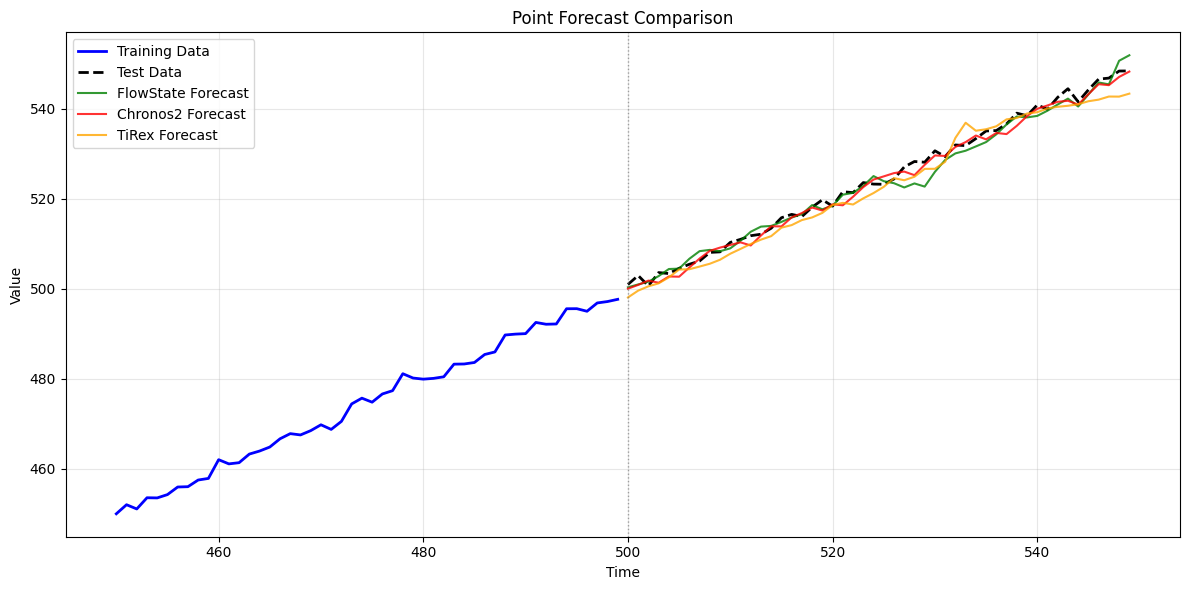

In [6]:
# Plot all forecasts together
fig, ax = plt.subplots(figsize=(12, 6))

# Plot only last 'horizon' points of training data
train_context_start = max(0, train_size - horizon)
train_context_indices = np.arange(train_context_start, train_size)
ax.plot(train_context_indices, train_data[0, train_context_start:, 0], label="Training Data", color="blue", linewidth=2)

# Plot test data
test_indices = np.arange(train_size, train_size + horizon)
ax.plot(test_indices, test_data[0, :, 0], label="Test Data", color="black", linewidth=2, linestyle="--")

# Plot forecasts
colors = {"FlowState": "green", "Chronos2": "red", "TiRex": "orange"}
for name, pred in models.items():
    ax.plot(test_indices, pred[0, :, 0], label=f"{name} Forecast", color=colors[name], linewidth=1.5, alpha=0.8)

ax.axvline(x=train_size, color="gray", linestyle=":", linewidth=1, alpha=0.7)
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Point Forecast Comparison")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Quantile Forecasts. Chronos2 supports custom quantile levels, while TiRex and FlowState can only return the default ones.

In [7]:
# Generate quantile forecasts from all three models
quantile_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

flowstate_q_request = FlowStateForecastRequest(
    x=train_data, horizon=horizon, prediction_type="quantile", output_type="quantiles"
)
flowstate_q_response = client.forecast(flowstate_q_request)

chronos2_q_request = Chronos2ForecastRequest(
    x=train_data, horizon=horizon, output_type="quantiles", quantiles=quantile_levels
)
chronos2_q_response = client.forecast(chronos2_q_request)

tirex_q_request = TiRexForecastRequest(x=train_data, horizon=horizon, output_type="quantiles")
tirex_q_response = client.forecast(tirex_q_request)

# Create dictionary of quantile models for visualization
quantile_models = {
    "FlowState": flowstate_q_response.quantiles,
    "Chronos2": chronos2_q_response.quantiles,
    "TiRex": tirex_q_response.quantiles,
}

print("Quantile forecasts generated successfully")

Quantile forecasts generated successfully


### Visualize Quantile Forecasts

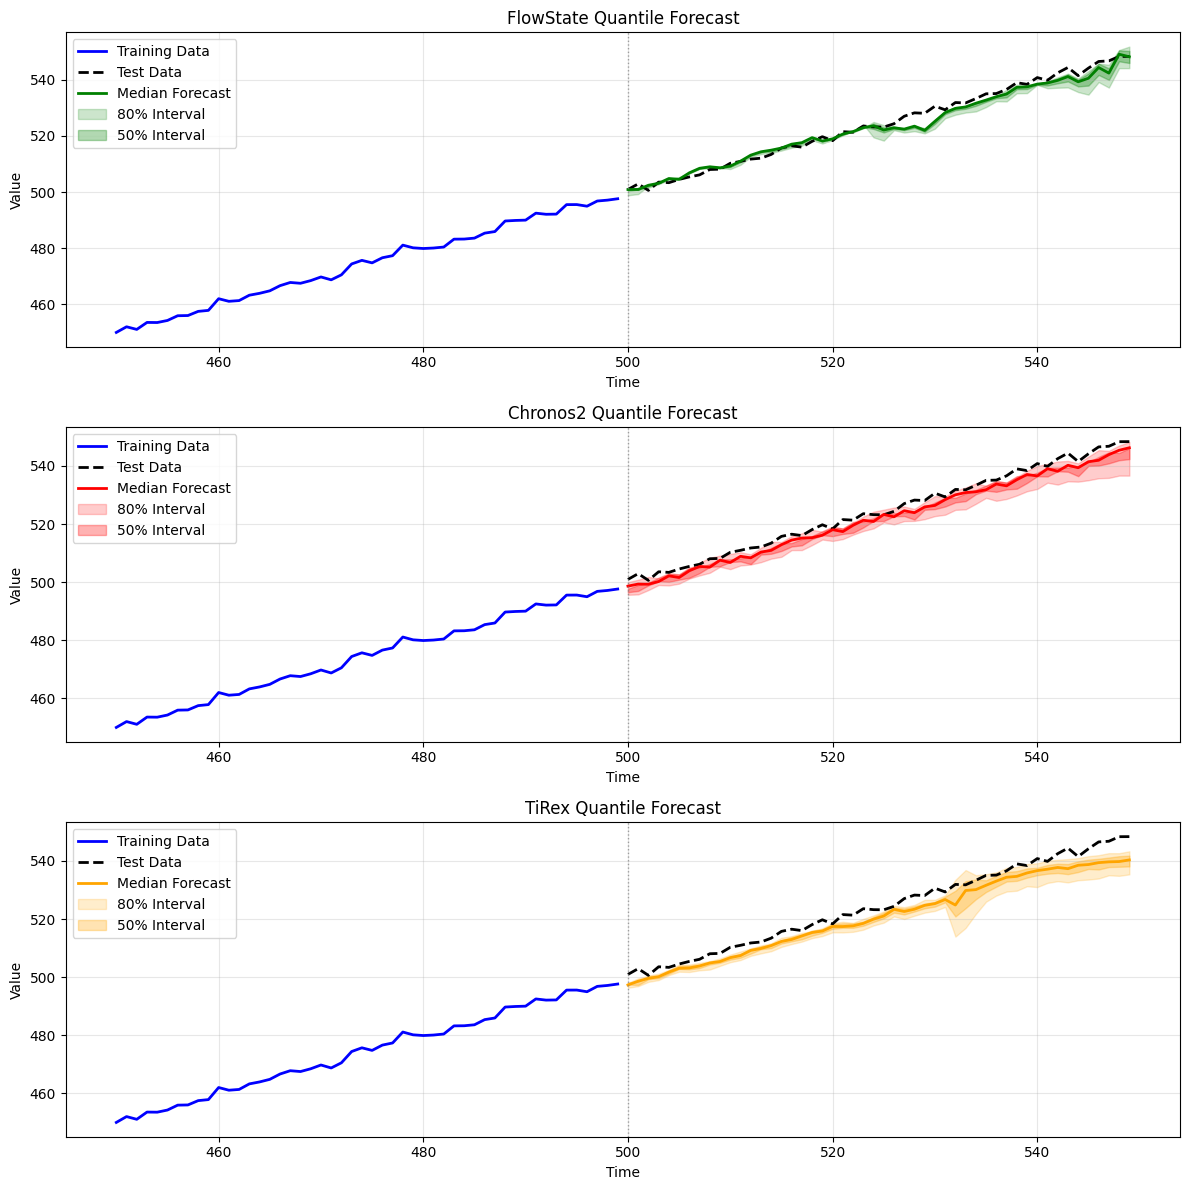

In [8]:
# Plot quantile forecasts for all models
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot only last 'horizon' points of training data
train_context_start = max(0, train_size - horizon)
train_context_indices = np.arange(train_context_start, train_size)

for idx, (name, quantiles) in enumerate(quantile_models.items()):
    ax = axes[idx]

    # Plot training data (last horizon points)
    ax.plot(
        train_context_indices, train_data[0, train_context_start:, 0], label="Training Data", color="blue", linewidth=2
    )

    # Plot test data
    ax.plot(test_indices, test_data[0, :, 0], label="Test Data", color="black", linewidth=2, linestyle="--")

    # Plot median (index 2 for 0.5 quantile)
    median_idx = 2
    ax.plot(test_indices, quantiles[0, :, median_idx, 0], label="Median Forecast", color=colors[name], linewidth=2)

    # Plot prediction intervals
    # 80% interval (0.1 to 0.9)
    ax.fill_between(
        test_indices,
        quantiles[0, :, 0, 0],  # 0.1 quantile
        quantiles[0, :, 4, 0],  # 0.9 quantile
        alpha=0.2,
        color=colors[name],
        label="80% Interval",
    )

    # 50% interval (0.25 to 0.75)
    ax.fill_between(
        test_indices,
        quantiles[0, :, 1, 0],  # 0.25 quantile
        quantiles[0, :, 3, 0],  # 0.75 quantile
        alpha=0.3,
        color=colors[name],
        label="50% Interval",
    )

    ax.axvline(x=train_size, color="gray", linestyle=":", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_title(f"{name} Quantile Forecast")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated how to use the FAIM platform to:

1. **Point Forecasting**: Compare FlowState, Chronos2, and TiRex models
2. **Evaluation Metrics**: Compute MSE and MASE for point forecasts
3. **Quantile Forecasting**: Generate probabilistic forecasts with uncertainty intervals